# Installing libraries 

- regex: Advanced regular expressions library for searching and manipulating text.
- tqdm: Fast, extensible progress bar for loops and iterable objects.
- diffusers by Hugging Face:: Diffusers provides pretrained vision and audio diffusion models, and serves as a modular toolbox for inference and training
- transformers by Hugging Face:: Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models.
- scipy: Scientific computing library for optimization, integration, and other mathematical operations.
- accelerate by Hugging Face: In short, training and inference at scale made simple, efficient and adaptable
- Xformers: Optimizes transformers architecture. Toolbox to Accelerate Research on Transformers
- opencv: OpenCV is a library of programming functions mainly for real-time computer vision

In [1]:
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python

In [2]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q pycocotools matplotlib onnxruntime onnx

^C
ERROR: Operation cancelled by user


# Importing libraries

In [1]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

import sys

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Checking for Memory Usage Limit

In [2]:
import psutil

# Get the memory limit in bytes
memory_limit_bytes = psutil.virtual_memory().total

# Convert to gigabytes for better readability
memory_limit_gb = memory_limit_bytes / (1024 ** 3)

print(f"Memory Limit: {memory_limit_gb:.2f} GB")

Memory Limit: 16.00 GB


# Accessing GPU Acceleration on mps device 

In [3]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

**For Cuda**

In [2]:
if torch.cuda.is_available():
    print("CUDA is available on this system!")
else:
    print("CUDA is not available on this system.")

CUDA is not available on this system.


# Downloading the "segment anything" model checkpoint

The Segment Anything Model (SAM) produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image. It has been trained on a dataset of 11 million images and 1.1 billion masks, and has strong zero-shot performance on a variety of segmentation tasks.
- https://github.com/facebookresearch/segment-anything

example notebooks: 
- https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
- https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

**Loading the Model might take some time (2,9GB)**

In [6]:
### Downloading checkpoint file to same folder where the notebook is
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

zsh:1: command not found: wget


In [ ]:
import requests

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"

response = requests.get(url)
if response.status_code == 200:
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"Downloaded {filename}")
else:
    print(f"Failed to download {filename}")

# Loading and Preproccessing our Image

In [6]:
image = cv2.imread('Photos/photo-1602092078592-784556bba6c4.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  ## Converting to RGB color 

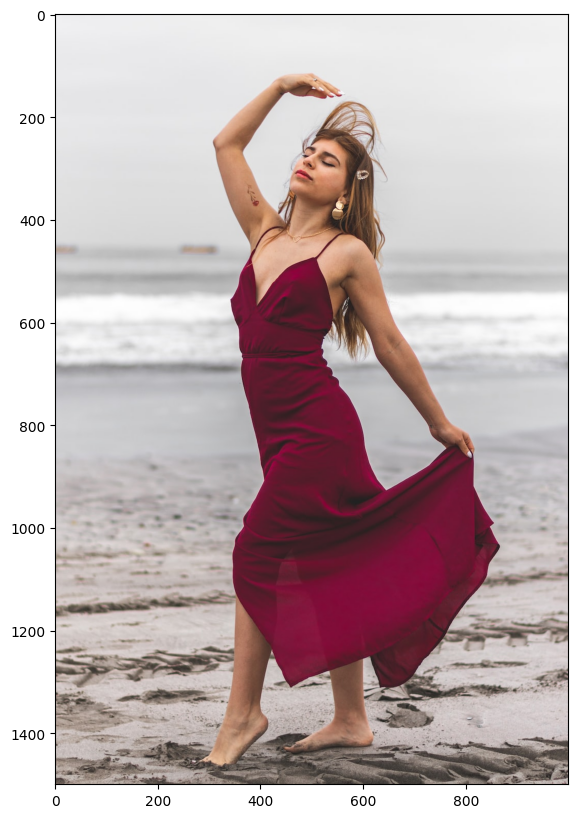

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

**Reshaping Image for improved memory usage**

In [8]:
target_width, target_height = 512, 512
source_image = Image.open('Photos/photo-1602092078592-784556bba6c4.jpeg')

width, height = source_image.size
print(f"Source image size: {source_image.size}")

# Making the image square 
# source_image = source_image.crop((0, height-width, width, height))  ## box=(left, upper, right, lower)

# Resizing the Image to our target dimensions to improve memory usage 
source_image = source_image.resize((target_width, target_height), Image.LANCZOS)
print(f"Target image size: {source_image.size}")

segmentation_image = asarray(source_image)  ## Comment !!! 

Source image size: (1000, 1500)
Target image size: (512, 512)


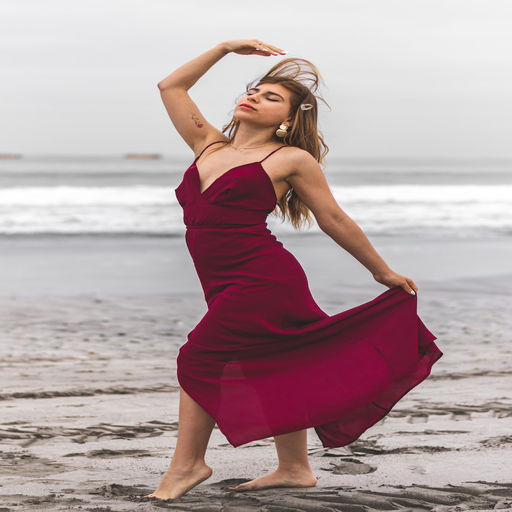

In [9]:
display(source_image)

# Automatic Mask Generator

In [10]:
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry

sam_checkpoint = "SAM_checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)

Next, to generate masks, we can simply run the ".generate" function on our Image

In [11]:
masks = mask_generator.generate(segmentation_image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- segmentation : the mask
- area : the area of the mask in pixels
- bbox : the boundary box of the mask in XYWH format
- predicted_iou : the model's own prediction for the quality of the mask
- point_coords : the sampled input point that generated this mask
- stability_score : an additional measure of mask quality
- crop_box : the crop of the image used to generate this mask in XYWH format

In [12]:
print(len(masks))
print(masks[0].keys())

26
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [13]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

Showing all the automatic generated masks of our image

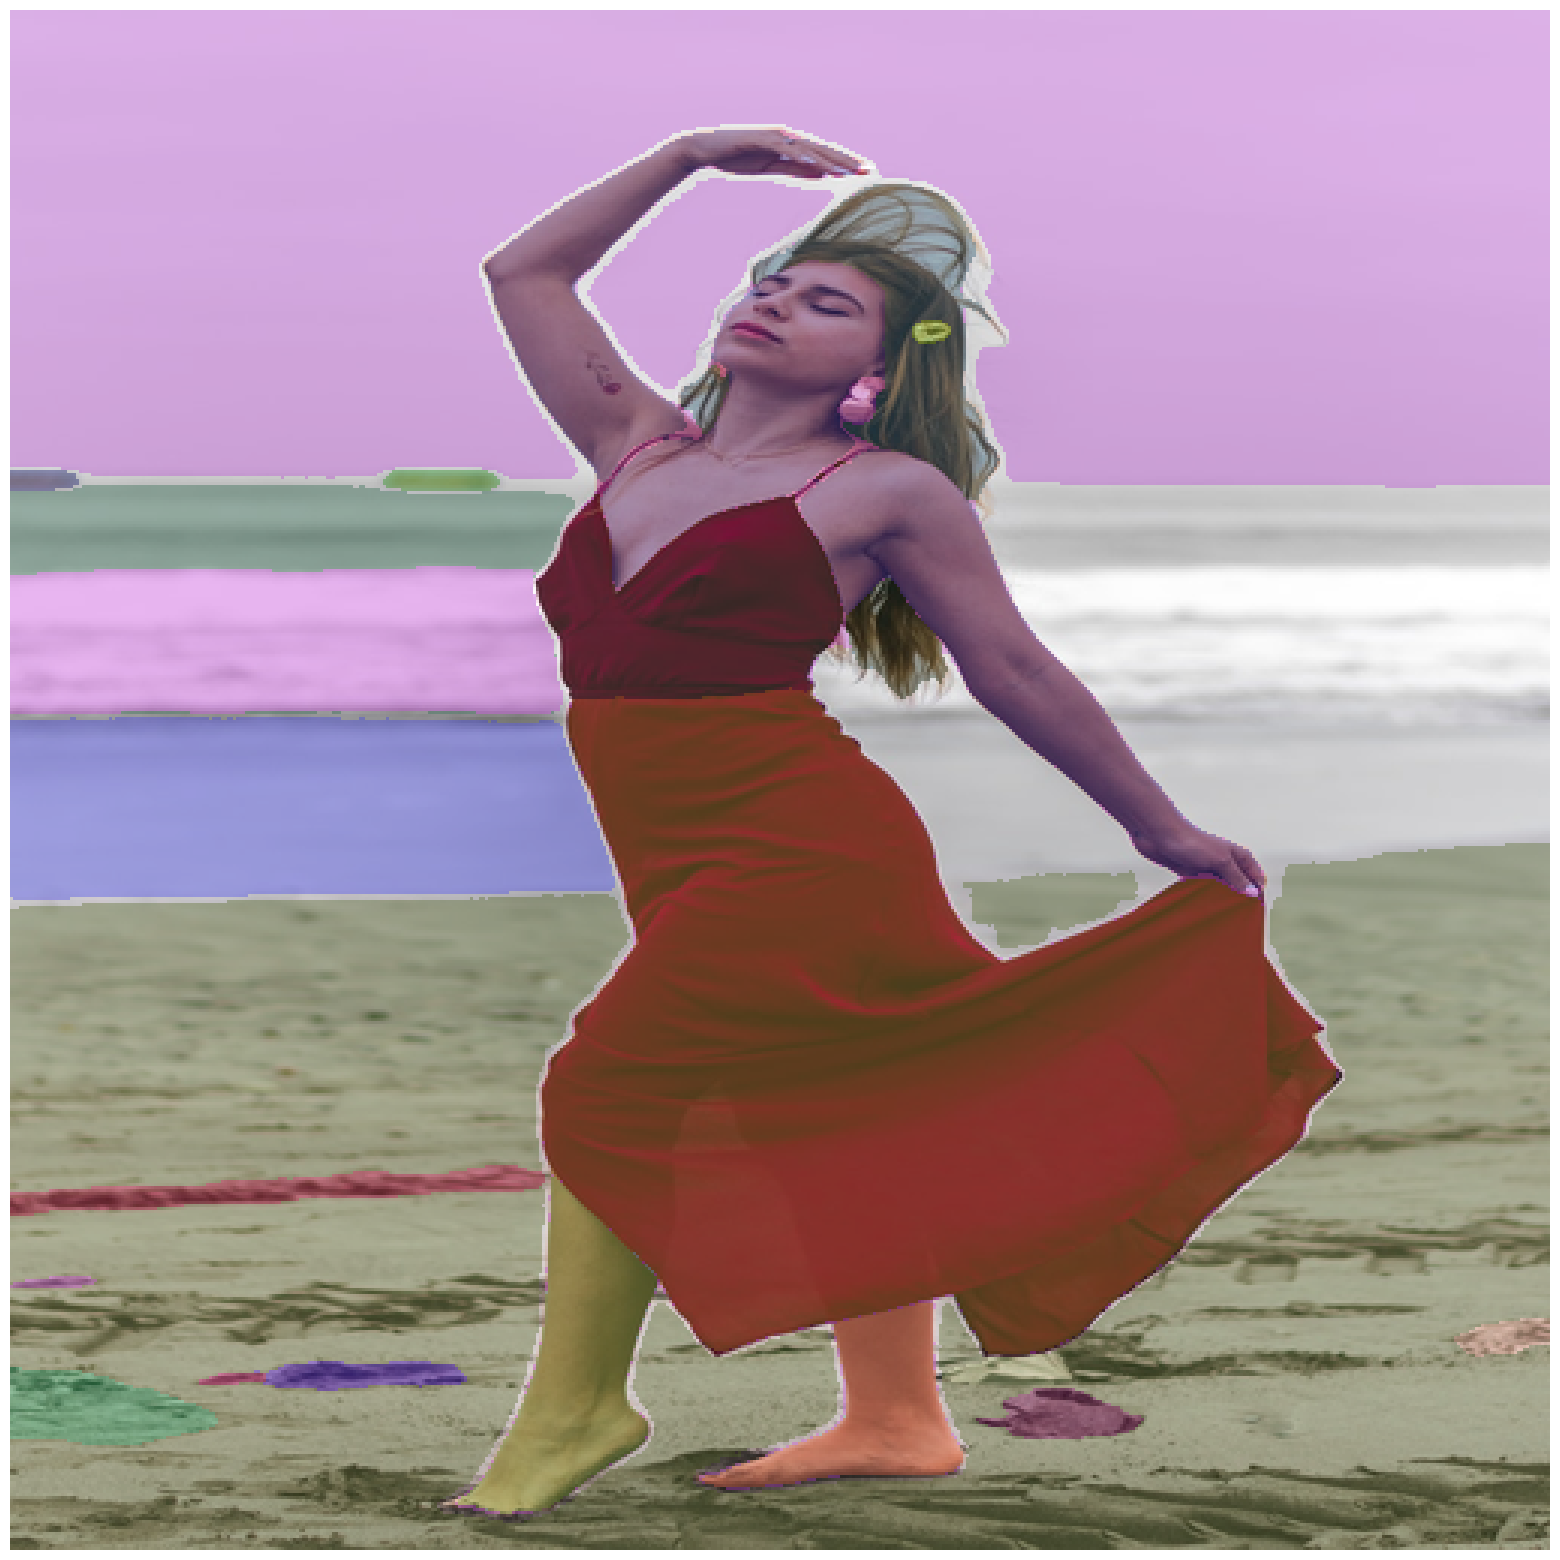

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks)
plt.axis('off')
plt.show()

# Tunable options for Automatic Mask Generation 

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. 

In [15]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,   ## The higher the value, the more detailed the generated mask will be
    pred_iou_thresh=0.86,  ## controls the prediction IoU score 
    stability_score_thresh=0.92,  ## measures consistency/stability for predictions with threshold
    crop_n_layers=1,  ## controls lvl of detail in generated masks 
    crop_n_points_downscale_factor=2,  ## 
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [16]:
masks2 = mask_generator_2.generate(segmentation_image)

In [17]:
print(len(masks2))

41


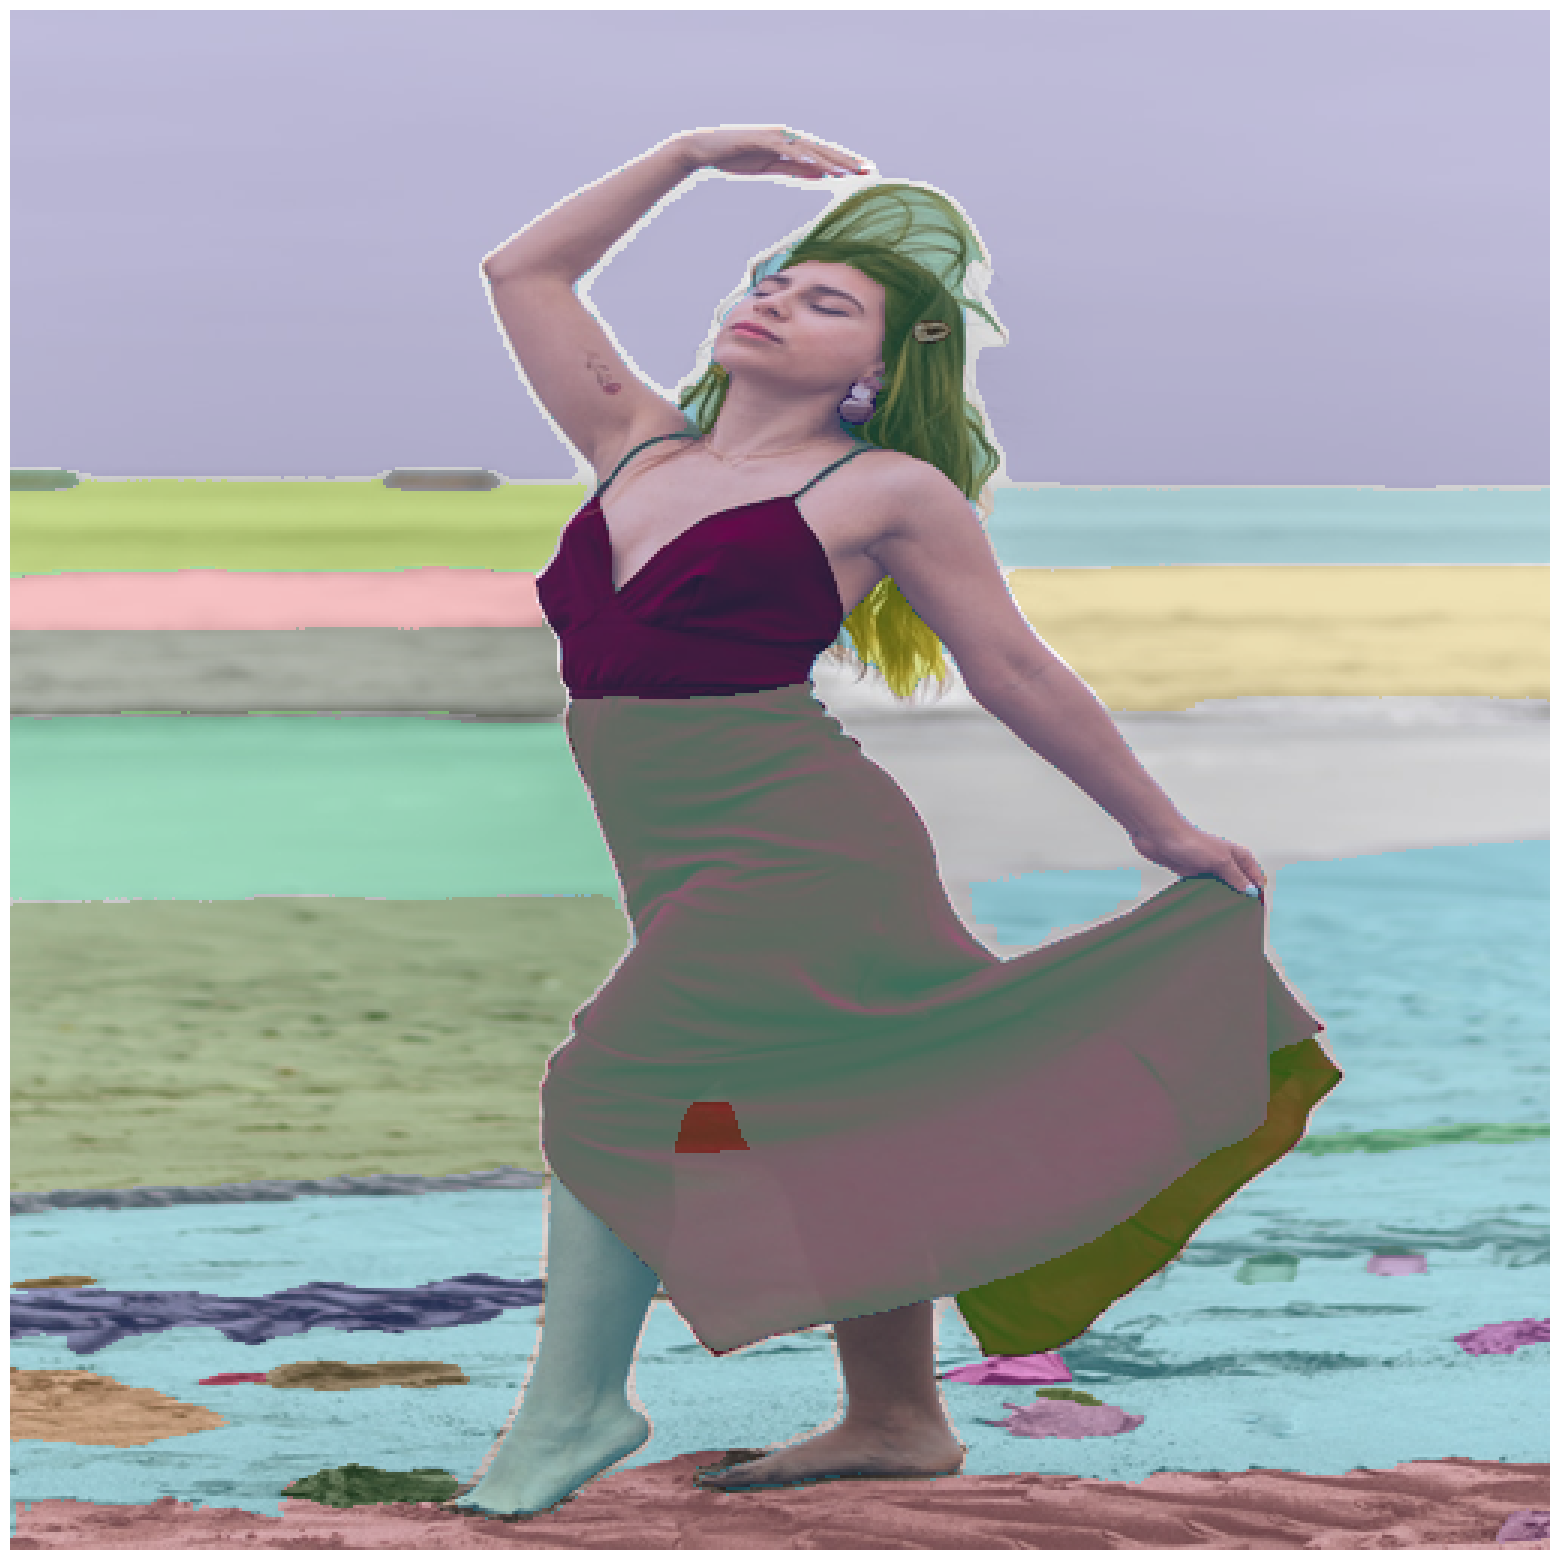

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks2)
plt.axis('off')
plt.show()

As you can see we just created a lot of (detailled) masks. Since we want to make an accurate, detailed and clean mask of the dress in the middle part we can adjust the parameters as follow => 

In [19]:
mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,   
    pred_iou_thresh=0.86,  
    stability_score_thresh=0.92, 
    crop_n_layers=1,  
    crop_n_points_downscale_factor=2,   
    min_mask_region_area=100,
)

In [20]:
masks3 = mask_generator_3.generate(segmentation_image)
print(len(masks3))

10


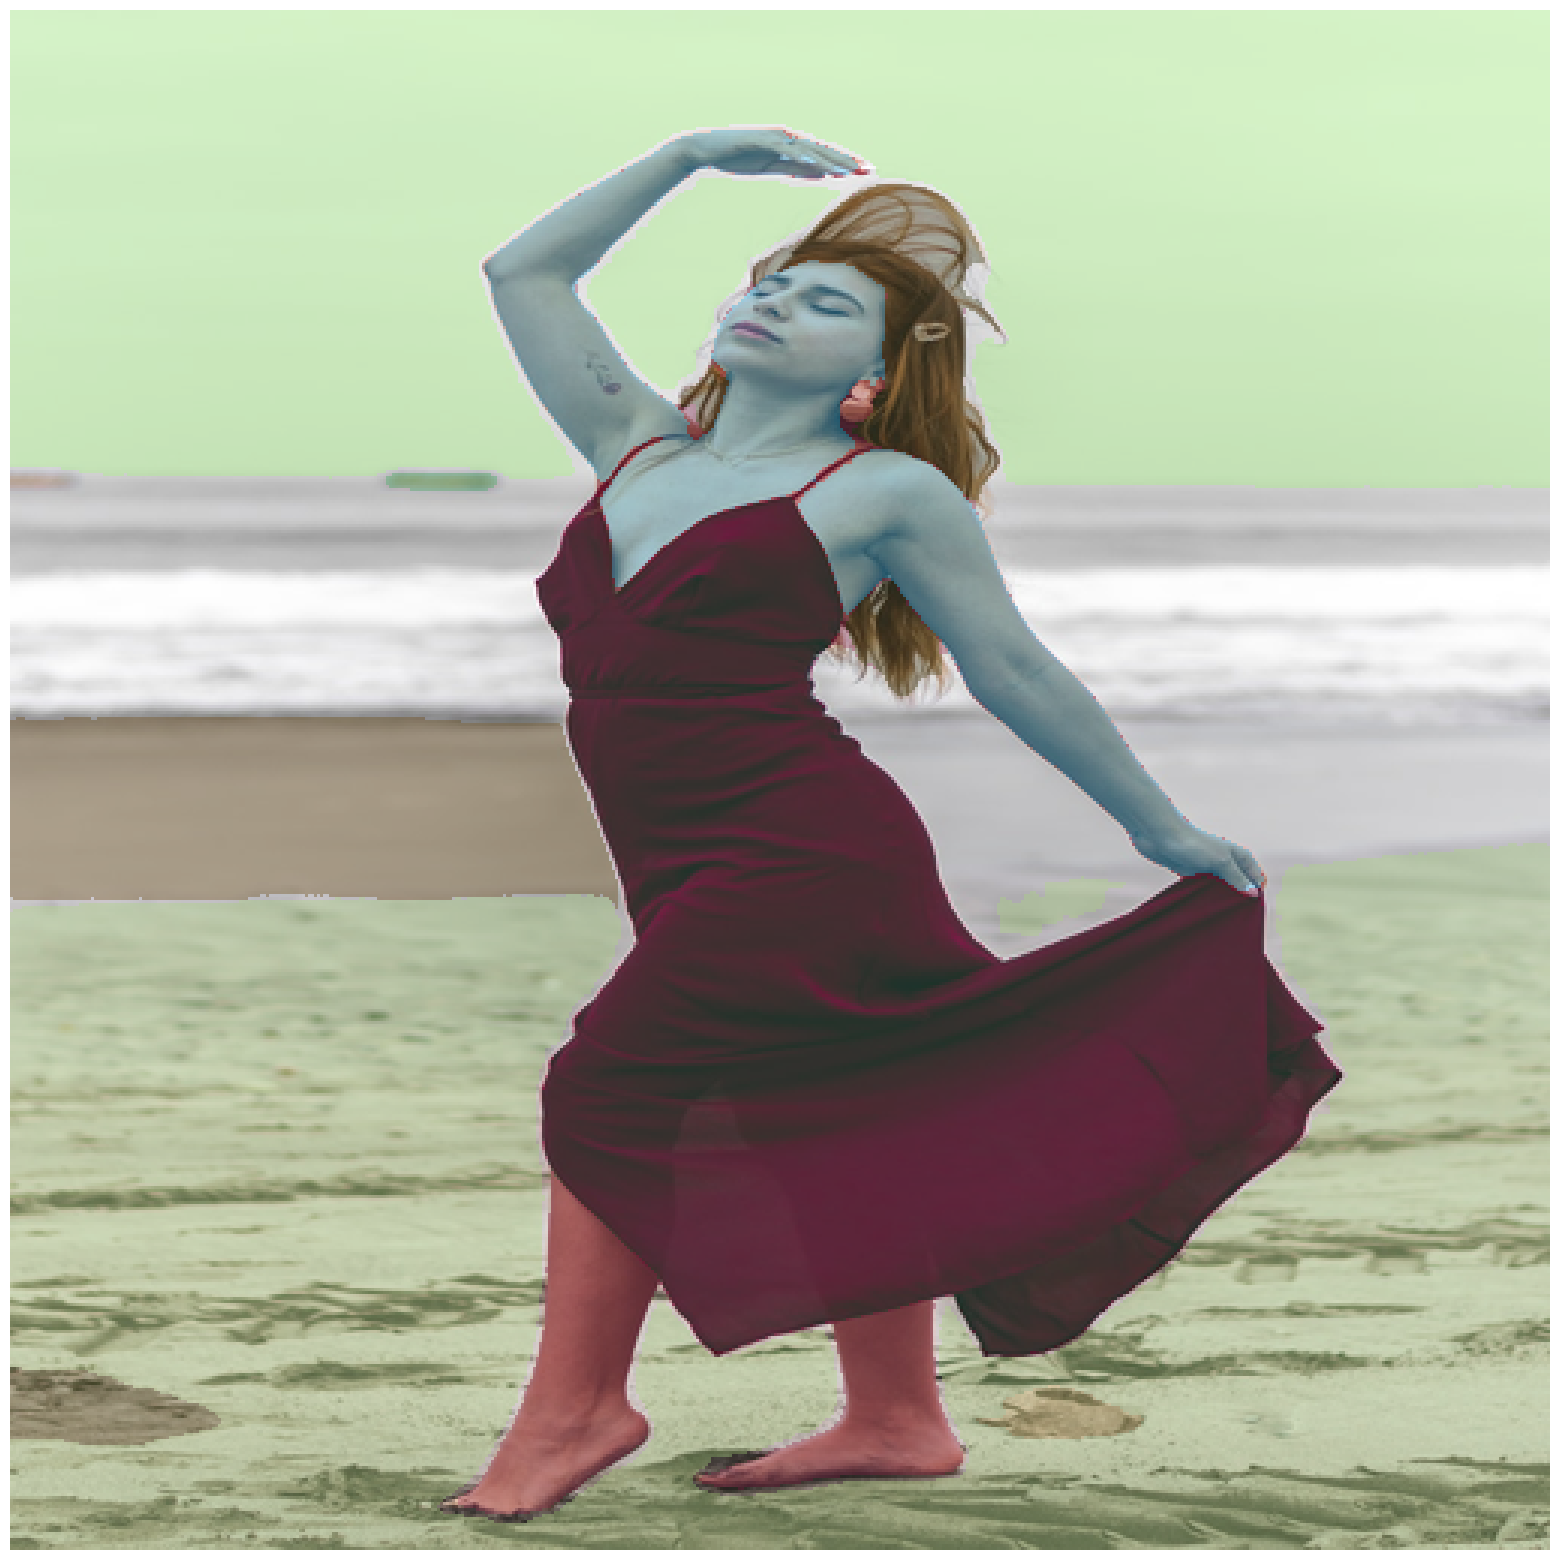

In [21]:
plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks3)
plt.axis('off')
plt.show()

# Object Masks from Prompt with SAM 

In [22]:
sam_checkpoint = "SAM_checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=mps_device)

predictor = SamPredictor(sam)

Creating an image embedding for accurate and subsequent mask predictions

In [23]:
predictor.set_image(segmentation_image)

**Creating some helper functions to choose our wanted mask** 

In [24]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

Next, to select the attribute/object wherefore we want to create a mask, we will select this by using a point that we can adjust accordingly, because of our helper functions, we are able to visualize our chosen point and visualize it in the picture

In [25]:
input_point = np.array([[250, 300]])
input_label = np.array([1])

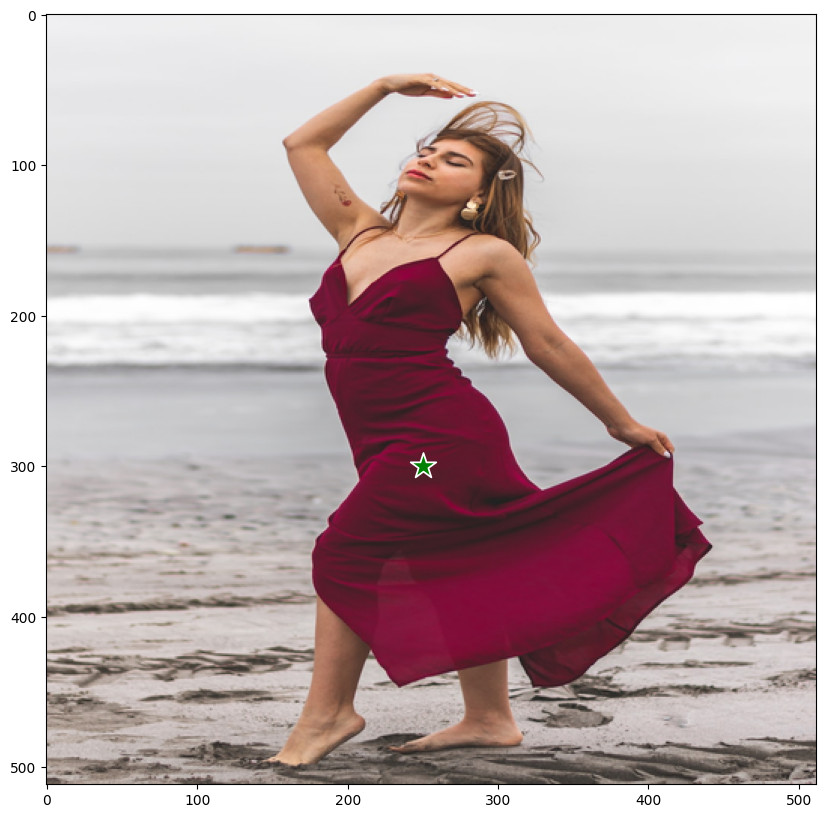

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(source_image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

By using the SamPredictor(which we initialized as "predictor").predict the model will return us the (quality) masks of our selected point. 

In [27]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
## Altough you can set the multimask_ouput to False, it is not intended to so, even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

/Users/wout_vp/venv-metal/lib/python3.11/site-packages/segment_anything/modeling/mask_decoder.py:126: UserWarning: MPS: no support for int64 repeats mask, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Repeat.mm:236.)
  src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)


In [28]:
masks.shape  # (number_of_masks) x H x W

(3, 512, 512)

Now, we will loop over our list with created masks and their scores and plot these

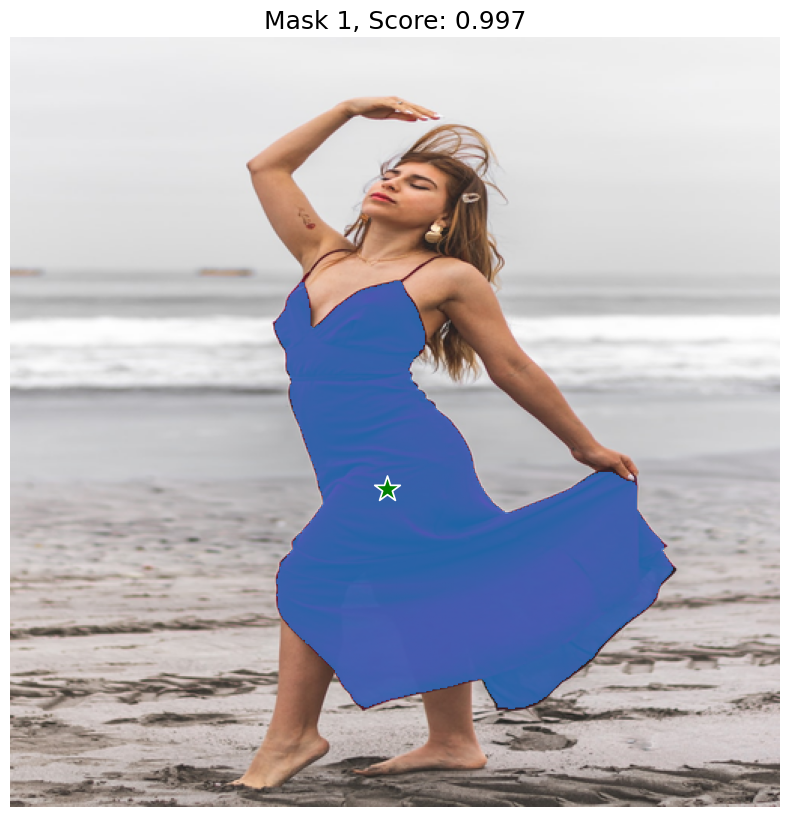

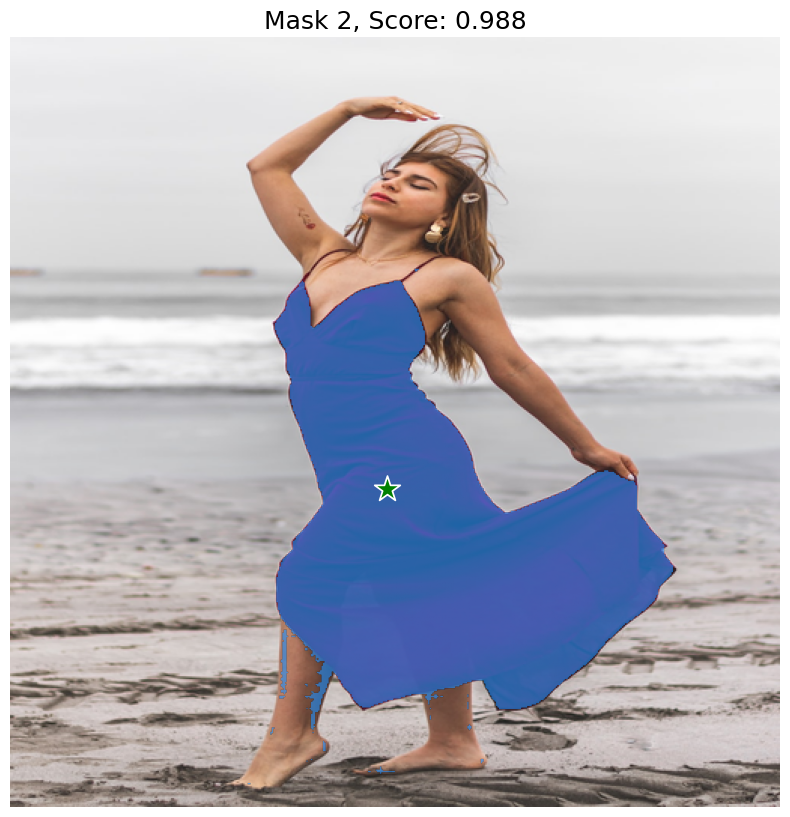

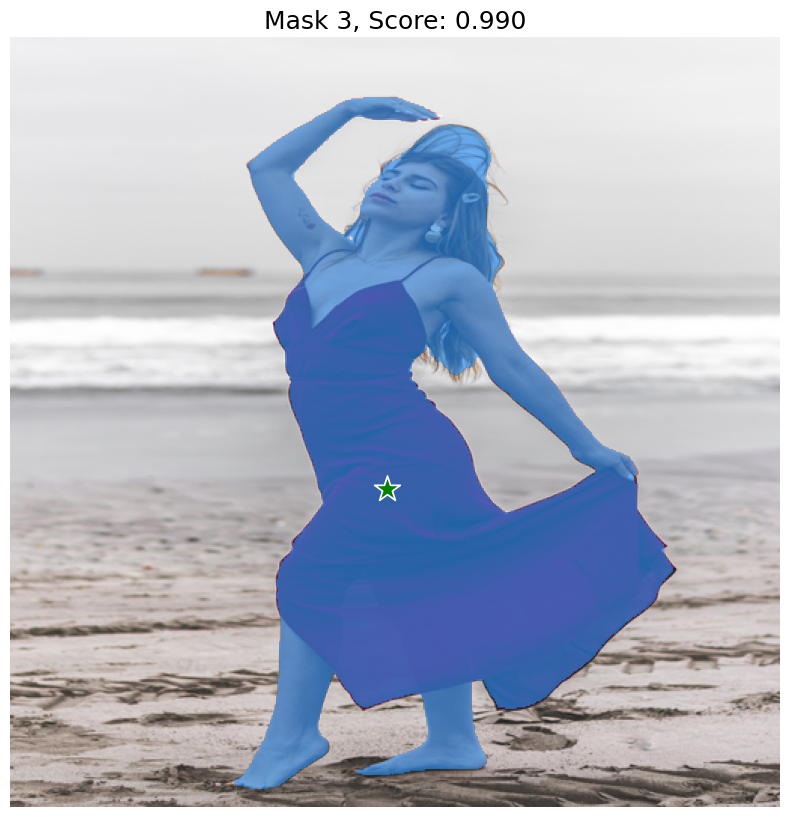

In [29]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(source_image)   ## Displays original image 
    show_mask(mask, plt.gca())  ## Overlays the masks over the original mage
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

# Deciding and continuing with our preffered mask 

In [30]:
selected_mask_index = 0

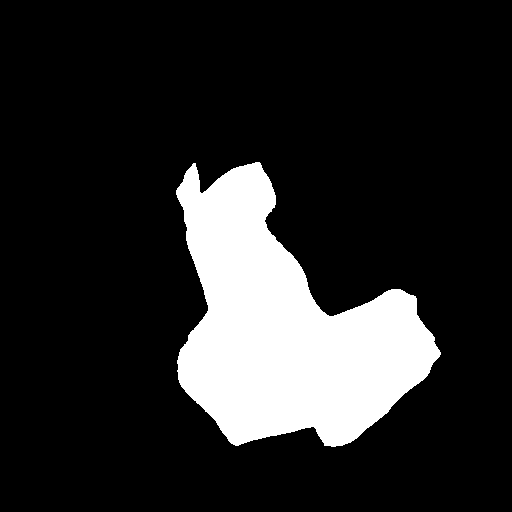

In [31]:
selected_mask = masks[selected_mask_index]
stable_diffusion_mask = PIL.Image.fromarray(selected_mask)
display(stable_diffusion_mask)

#plt.figure(figsize=(10, 10))
#plt.imshow(selected_mask)
#plt.title(f"Selected Mask {selected_mask_index + 1}", fontsize=18)
#plt.axis('off')
#plt.show()

# Importing our Stable Diffusion Model 

Stable Diffusion is a latent text-to-image diffusion model capable of generating photo-realistic images given any text input. 
https://github.com/CompVis/stable-diffusion

- StableDiffusionInpaintPipeline is used to create a pipeline for inpainting using the Stable Diffusion model.
- EulerDiscreteScheduler is used to determine the algorithm used for generating new samples during the denoising process.
- **Inpainting Model:** https://huggingface.co/stabilityai/stable-diffusion-2-inpainting

**For Cuda Devices** 

In [ ]:
#from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

#model_dir = "stabilityai/stable-diffusion-2-inpainting"
#scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

#pipeline = StableDiffusionInpaintPipeline.from_pretrained(model_dir, 
                                                   #scheduler=scheduler,
                                                   #revision="fp16",
                                                   #torch_dtype=torch.float16)
#pipeline.enable_xformers_memory_efficient_attention()

**For Apple Silicon (M1/M2):** https://huggingface.co/docs/diffusers/optimization/mps

In [32]:
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler # DiffusionPipeline,

# pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16)  
##  ==== General pipeline =====

model_dir = "stabilityai/stable-diffusion-2-inpainting"
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir, 
                                                         scheduler=scheduler,
                                                         revision="fp16",
                                                         torch_dtype=torch.float16,
                                                     )

pipe = pipe.to("mps")

pipe.enable_attention_slicing()  
# pipe.enable_xformers_memory_efficient_attention()   ==== only if working with cuda ====

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/Users/wout_vp/venv-metal/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


# Setting up the transformation prompts

In [ ]:
num_images_per_prompt = 4
inpainting_prompt = ["a skirt full of text", "green flowers", "blue skulls", "brand logos"]

generator = torch.Generator("mps").manual_seed(37)

## Running the Stable diffusion Pipeline in "inpainting" mode
encoded_images = []
for i in range(num_images_per_prompt):
    image = pipe(prompt=inpainting_prompt[i], guidance_scale=7.5, num_inference_steps=10, generator=generator, image=source_image, mask_image=stable_diffusion_mask)
    encoded_images.append(image)

**Creating a function that takes our prompts as an input and outputs an image grid with our desired transformations** 

In [ ]:
def create_image_grid(original_image, images, names, rows, columns):

    # Creating a copy of the names and images lists to avoid modifying the external variable
    names = copy.copy(names)  
    images = copy.copy(images)  

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()

In [ ]:
create_image_grid(source_image, encoded_images, inpainting_prompt, 2, 3)